In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy import stats
from vnstock import *

In [20]:
vn = pd.read_csv("vn_price.csv", index_col="TradingDate", parse_dates=True)

In [21]:
vn.columns

Index(['AAA', 'AAM', 'AAT', 'ABR', 'ABS', 'ABT', 'ACB', 'ACC', 'ACG', 'ACL',
       ...
       'VPS', 'VRC', 'VRE', 'VSC', 'VSH', 'VSI', 'VTB', 'VTO', 'YBM', 'YEG'],
      dtype='object', length=406)

In [73]:
start = "2023-01-01"
end = "2023-03-31"
df = vn[(pd.Timestamp(start).date()<=vn.index.date)&(vn.index.date<=pd.Timestamp(end).date())][["VIC","YEG"]]

In [74]:
df.to_csv("k1.csv")

a) Tính chuỗi dữ liệu về Tỷ suất lợi nhuận theo phương pháp liên tục

In [75]:
ti_suat = np.log(df/df.shift(1))

In [76]:
ti_suat.dropna(inplace=True)
ti_suat

,VIC,YEG
TradingDate,,
2023-01-04,-0.014185,0.000000
2023-01-05,0.003565,-0.072053
2023-01-06,-0.001781,0.021604
2023-01-09,-0.019803,-0.019308
2023-01-10,-0.009132,-0.011534
2023-01-11,0.010949,-0.002323
2023-01-12,-0.001817,0.011561
2023-01-13,0.000000,-0.006920
2023-01-16,-0.003643,-0.023420


b) Lấy thông tin về Thống kê mô tả của hai chuỗi Tỷ suất lợi nhuận nói trên trong Excel

In [77]:
ti_suat.describe()

,VIC,YEG
count,37.000000,37.000000
mean,-0.002076,0.003645
std,0.013084,0.031352
min,-0.033841,-0.072053
25%,-0.009407,-0.011534
50%,-0.001781,0.004202
75%,0.003578,0.021604
max,0.030877,0.066262


c) Lập danh mục đầu tư hai cổ phiếu với Tỷ trọng thay đổi.  Tính Tỷ suất lợi nhuận của danh mục theo hai cách : trực tiếp và gián tiếp.

Danh mục

In [78]:
weights = df.div(df.abs().sum(axis=1), axis=0)

In [79]:
weights.shift(1)

,VIC,YEG
TradingDate,,
2023-01-03,NaN,NaN
2023-01-04,0.858655,0.141345
2023-01-05,0.856924,0.143076
2023-01-06,0.865948,0.134052
2023-01-09,0.863210,0.136790
2023-01-10,0.863151,0.136849
2023-01-11,0.863435,0.136565
2023-01-12,0.864992,0.135008
2023-01-13,0.863422,0.136578


In [80]:
ti_suat_danh_muc = np.sum(weights.shift(1)*ti_suat,axis=1)

d) Kiểm chứng tính chuẩn của Tỷ suất lợi nhuận các cổ phiếu và danh mục.

In [81]:
from scipy.stats import jarque_bera
jb_value_VIC, p_value_VIC = jarque_bera(ti_suat["VIC"])
jb_value_YEG, p_value_YEG = jarque_bera(ti_suat["YEG"])
jb_value_port, p_value_port = jarque_bera(ti_suat_danh_muc)

In [83]:
print(f"VIC p_value: {p_value_VIC}")
print(f"YEG p_value: {p_value_YEG}")
print(f"Portfolio p_value: {p_value_port}")

VIC p_value: 0.6739738959994697
YEG p_value: 0.514880400492751
Portfolio p_value: 0.847179395507333


<Axes: ylabel='Density'>

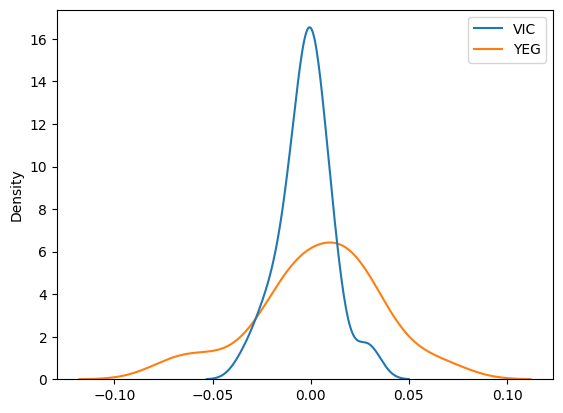

In [84]:
sns.kdeplot(ti_suat)

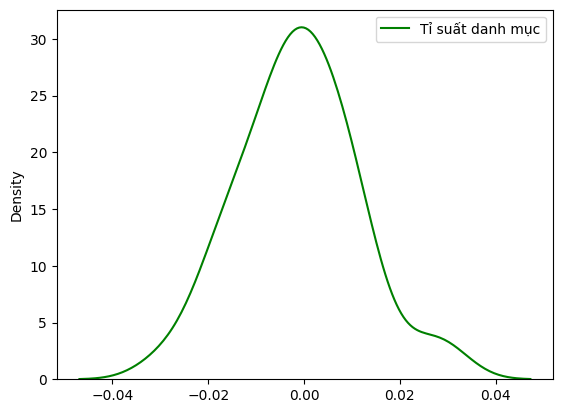

In [85]:
sns.kdeplot(ti_suat_danh_muc,color="green",label="Tỉ suất danh mục")
plt.legend()

Vậy YEG phân phối chuẩn

e) Giả sử có một trong 3 chuỗi trên phân phối chuẩn hãy viết Phương trình động thái giá (hoặc danh mục) theo mô hình chuyển động Brown hình học.

Giả sử mô hình chuyển động của giá là $S(t)=S(0)e^{\sigma B_t+(\mu-\frac12 \sigma^2)t}$
#### Ước lượng $\mu$
$$
\begin{aligned}
&\Rarr r=\frac{dS_t}{S_t}=\mu dt+\sigma dB_t\\
&\Rarr E(r)=E(\frac{dS_t}{S_t})=E(\mu dt+\sigma dB_t)\\
&\Rarr E(r)=E(\mu dt)+E(\sigma dB_t)\\
&\Rarr E(r)=\mu E(dt)\\
&\Rarr \frac{E(r)}{dt}=\mu
\end{aligned}
$$

#### Ước lượng $\sigma$
$$
\begin{aligned}
&\Rarr r=\frac{dS_t}{S_t}=\mu dt+\sigma dB_t\\
&\Rarr V(r)=V(\frac{dS_t}{S_t})=V(\mu dt+\sigma dB_t)\\
&\Rarr V(r)=V(\mu dt)+V(\sigma dB_t)\\
&\Rarr V(r)=\sigma^2 \times dt\\
&\Rarr \sqrt{\frac{V(r)}{dt}}=\sigma
\end{aligned}
$$

In [86]:
def mu_sigma(tisuat,hs):
    mu = (tisuat.mean())*hs
    sigma = np.sqrt(tisuat.var()*hs)
    return mu, sigma

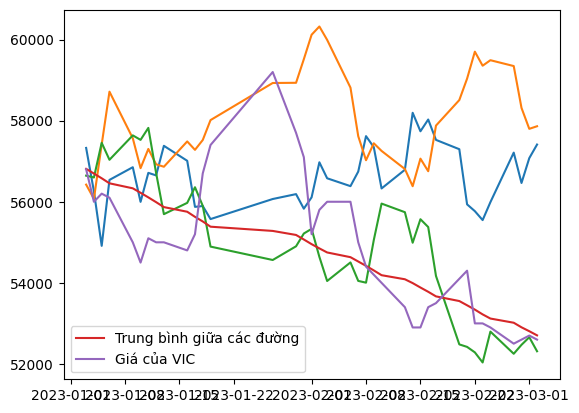

In [92]:
ticker = "VIC"
mu, sigma =  mu_sigma(ti_suat[ticker],len(ti_suat))

T=1
N=len(df) # Số bước 
M=10000 # Số kịch bản
dt=T/N
t=np.arange(0,1,dt)
dW = np.sqrt(dt)*np.random.randn(M,N)
W = np.cumsum(dW,axis=1)
S0 = df[ticker][0]

U=np.exp((mu-0.5*sigma**2)*t+sigma*W)
Umean = np.mean(U,axis=0)
plt.plot(df.index,S0*U[:3].T) #Vẽ 5 đường
plt.plot(df.index,S0*Umean,label="Trung bình giữa các đường")
plt.plot(df[ticker],label=f"Giá của {ticker}")
plt.legend()
plt.show()

In [36]:
df[['r_VIC','r_YEG']]=ti_suat
df[["a_VIC","a_YEG"]]=weights
df["returns"]=(weights.shift(1)*ti_suat).sum(axis=1)
df

,VIC,YEG,r_VIC,r_YEG,a_VIC,a_YEG,returns
TradingDate,,,,,,,
2013-02-25,18247.0,NaN,NaN,NaN,1.000000,NaN,0.000000
2013-02-26,17545.0,NaN,NaN,NaN,1.000000,NaN,0.000000
2013-02-27,17826.0,NaN,NaN,NaN,1.000000,NaN,0.000000
2013-02-28,18809.0,NaN,NaN,NaN,1.000000,NaN,0.000000
2013-03-01,18528.0,NaN,NaN,NaN,1.000000,NaN,0.000000
...,...,...,...,...,...,...,...
2023-02-24,52900.0,10600.0,-0.001889,-0.063949,0.833071,0.166929,-0.012795
2023-02-27,52500.0,10000.0,-0.007590,-0.058269,0.840000,0.160000,-0.016050
2023-02-28,52600.0,10400.0,0.001903,0.039221,0.834921,0.165079,0.007874
